In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.spatial
import sklearn.pipeline
import sklearn.decomposition
import MulticoreTSNE
import keras
import keras.datasets
import keras.backend as K

/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(data, label), (test_data, test_label) = keras.datasets.mnist.load_data()
data = np.reshape(data, (data.shape[0], data.shape[1]*data.shape[2]))
data = data / 255
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1]*test_data.shape[2]))
test_data = test_data / 255
data.shape

(60000, 784)

In [3]:
tsne = sklearn.pipeline.Pipeline([
    ('pca', sklearn.decomposition.PCA(50)),
    ('tsne', MulticoreTSNE.MulticoreTSNE(verbose=True, n_jobs=8)),
])
tsne_data = tsne.fit_transform(data)

In [4]:
X = X_input = keras.layers.Input((data.shape[-1],))
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Dropout(0.5)(X)
X = keras.layers.Dense(512, kernel_initializer='he_normal')(X)
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Activation('relu')(X)
X = keras.layers.Dense(256, kernel_initializer='he_normal')(X)
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Activation('relu')(X)
X = keras.layers.Dense(128, kernel_initializer='he_normal')(X)
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Activation('relu')(X)
X = keras.layers.Dense(2, kernel_initializer='he_normal')(X)
M = keras.Model(X_input, X)
M.compile('adam', loss='mse')
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 784)               3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
__________

<IPython.core.display.Javascript object>


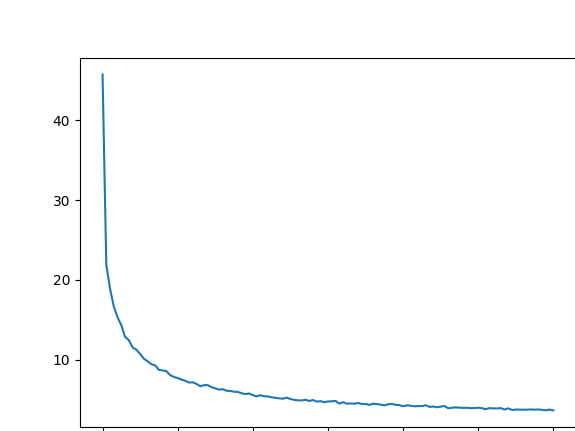

KeyboardInterrupt: 

In [5]:
%matplotlib notebook
plt.ion()
losses = []
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
def plot_loss(epoch, log):
    losses.append(log['loss'])
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
M.fit(data, tsne_data, batch_size=64, epochs=300, verbose=False, callbacks=[
    keras.callbacks.ReduceLROnPlateau('loss', factor=0.1, patience=10, verbose=True),
    keras.callbacks.LambdaCallback(on_epoch_end=plot_loss)
])

In [6]:
M_data = M.predict(data, batch_size=512)

In [7]:
tree = scipy.spatial.KDTree(M_data)

True
4.480789873796587 4.480789873796587 15.32913136346361


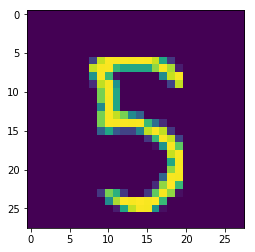

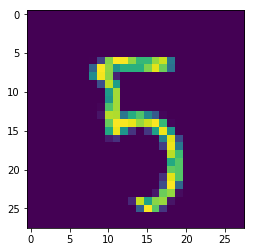

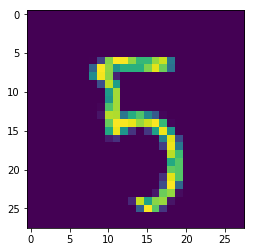

In [16]:
%matplotlib inline
plt.ioff()
def test(q):
    q = q[np.newaxis,:]
    q1 = M.predict(q)
    _, i = tree.query(q1, k=256)
    j = i[0][np.argmin(np.linalg.norm(data[i[0]] - q, axis=-1))]
    k = np.argmin(np.linalg.norm(data - q[0], axis=-1))
    l = np.argmax(np.linalg.norm(data - q[0], axis=-1))
    print(k in i[0])
    print(
        np.linalg.norm(q[0]-data[j]),
        np.linalg.norm(q[0]-data[k]),
        np.linalg.norm(q[0]-data[l]))
    plt.imshow(np.reshape(q[0], (28,28)))
    plt.show()
    plt.imshow(np.reshape(data[j], (28,28)))
    plt.show()
    plt.imshow(np.reshape(data[k], (28,28)))
    plt.show()
test(test_data[np.random.randint(0,test_data.shape[0])])

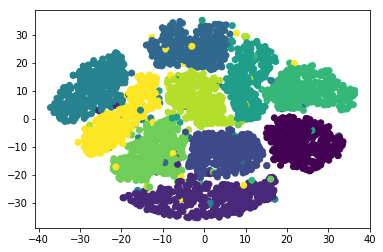

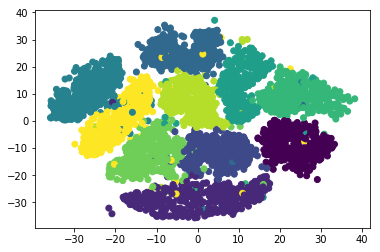

In [9]:
%matplotlib inline
N = 4096
plt.ioff()
plt.scatter(tsne_data[:N,0], tsne_data[:N,1], c=label[:N])
plt.show()
plt.scatter(M_data[:N,0], M_data[:N,1], c=label[:N])
plt.show()

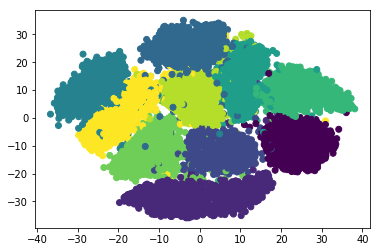

In [10]:
%matplotlib inline
M_test_data = M.predict(test_data)
plt.scatter(M_test_data[:,0], M_test_data[:,1], c=test_label)
plt.show()